In [219]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [220]:
#data stats boomb
competitions = pd.read_json(r'open-data-master/data/competitions.json')

In [221]:
#scrap data
concat_matchs = []
for i in competitions[competitions.competition_id == 11].season_id.to_list():
    matchs = pd.read_json(f'open-data-master/data/matches/11/{i}.json')
    concat_matchs.append(matchs)
    
matchs_messi = pd.concat(concat_matchs)

In [222]:
list_event = matchs_messi.match_id.to_list()

In [223]:
#scrap data only with messi event
event_messi_goal = []
for event in list_event:
    events = pd.read_json(f'open-data-master/data/events/{event}.json')
    events = events.dropna(subset=['player'])
    events = events.dropna(subset=['type'])
    events = events.reset_index(drop=True)
    for ids in range(len(events)):
        events.loc[ids, 'messi'] = events.loc[ids, 'player']['id']
        events.loc[ids, 'messishot'] = events.loc[ids, 'type']['name']
        
    events = events[(events['messi'] == 5503) & (events['messishot'] == 'Shot') ]

    event_messi_goal.append(events)

matchs_messi_event = pd.concat(event_messi_goal)

In [224]:
#save
matchs_messi_event.to_pickle('messishoot')

In [225]:
matchs_messi_event = pd.read_pickle(r'messishoot')

In [226]:
# data convert for localisation
matchs_messi_event = matchs_messi_event.reset_index(drop = True)
for shot in range(len(matchs_messi_event)):
    matchs_messi_event.loc[shot, 'x'] = matchs_messi_event.loc[shot, 'shot']['end_location'][1]
    if len(matchs_messi_event.loc[shot, 'shot']['end_location']) == 3:
        matchs_messi_event.loc[shot,'y'] = matchs_messi_event.loc[shot, 'shot']['end_location'][2]
    matchs_messi_event.loc[shot,'typeofshot'] = matchs_messi_event.loc[shot, 'shot']['type']['name']
    matchs_messi_event.loc[shot,'result'] = matchs_messi_event.loc[shot, 'shot']['outcome']['name']
    

In [227]:
#scale data (statsbomb center field = 60,40) 
matchs_messi_event['xM'] = [(float(i) / 80 * 68) for i in matchs_messi_event.x]

In [228]:
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
%matplotlib inline
from geopandas.tools import sjoin
import numpy as np

In [229]:
fp = r'FootballCage.geojson'

In [230]:
grid = gpd.read_file(fp)

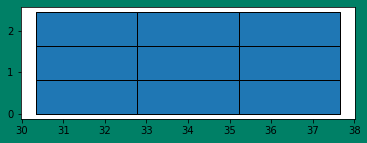

<Figure size 288x144 with 0 Axes>

In [231]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
fig.set_facecolor('#008066ff')
plt.figure(2, figsize=(4, 2))
grid.plot(ax = ax, edgecolor = 'black')

In [232]:
gdf = geopandas.GeoDataFrame(matchs_messi_event, geometry=geopandas.points_from_xy(matchs_messi_event.xM, matchs_messi_event.y))
gdf.crs = "EPSG:2154"

In [233]:
def goal_map(filtre1, filtre2):
    
    goal = gdf[(gdf['result'] == filtre1) & (gdf['typeofshot'] == filtre2)]
    
    # GiS Analysis with geopandas (nombre de points dans chaque polygon)
    f_goal = lambda x:np.sum(goal.intersects(x))
    grid['countGoal'] = grid['geometry'].apply(f_goal)
    
    # Plt 
    
    fig, ax = plt.subplots()
    ax.axis('off')
    fig.set_facecolor('#008066ff')
    ax.set_title(str('Messi ' + filtre1 + ' - ' + filtre2), fontdict = {'fontsize':12, 'color':'white'})
    
    
    #add grid GiS Analysis
    grid.plot(ax = ax, cmap='winter', column='countGoal', alpha=0.65)
   

    #add cage de foot ! 
    ly4 = [0,2.48,2.48,0]
    lx4 = [30.34,30.34,37.70,37.70]
    ax.plot(lx4,ly4,color='white',zorder=5, linewidth=5)
    ####

    #add labels
    grid.apply(lambda x: ax.annotate(
        s=int(round(x.countGoal,0)), 
        xy=x.geometry.centroid.coords[0], 
        ha='center',  
        color = "white", 
        fontweight='bold'),axis=1)

    #add scatter localisation shoot
    ax.scatter(goal.xM.to_list(), goal.y.to_list(), c = 'red', zorder=1, alpha=0.5, lw=0)

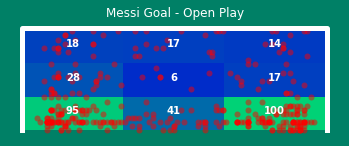

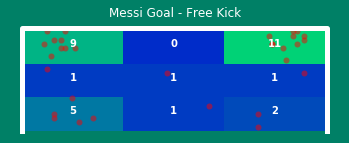

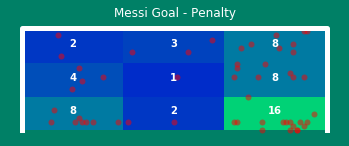

In [234]:
listshoot = matchs_messi_event['typeofshot'].value_counts().index.to_list()

for i in listshoot:
    goal_map('Goal', i)